In [1]:
import numpy as np
import nibabel as nib
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool
import torch.optim as optim
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
subject_id = "100206"
subject_path = f"diffusion_data/{subject_id}/T1w/Diffusion"
dwi_img = nib.load(f'{subject_path}/data.nii.gz')
mask_img = nib.load(f'{subject_path}/nodif_brain_mask.nii.gz')

In [4]:
dwi_data = dwi_img.get_fdata()
original_mask = mask_img.get_fdata() > 0

print(f"DWI data shape: {dwi_data.shape}")  # (X, Y, Z, num_volumes)

DWI data shape: (145, 174, 145, 288)


In [5]:
gt_data = np.load('ground_truth_v2.npz')
ground_truth_tensors = gt_data['tensors'] # shape 936256(all voxels) x 6
ground_truth_gpu = torch.from_numpy(ground_truth_tensors).to(device)

In [6]:
# store original indices before any voxel filtering 
original_idx = np.where(original_mask)

In [7]:
original_idx

(array([ 12,  12,  12, ..., 130, 130, 130], dtype=int64),
 array([84, 84, 84, ..., 91, 91, 91], dtype=int64),
 array([55, 56, 57, ..., 45, 46, 47], dtype=int64))

In [8]:
# Map (x,y,z) to original linear index
coord_to_gtt = {}
for i in range(len(original_idx[0])):
    x, y, z = original_idx[0][i], original_idx[1][i], original_idx[2][i]
    coord_to_gtt[(x,y,z)] = i  # i is the index in ground_truth_tensors

In [9]:
bvals, bvecs = read_bvals_bvecs(f'{subject_path}/bvals', 
                               f'{subject_path}/bvecs')
gtab = gradient_table(bvals, bvecs)

# get b0 data and b0_avg
b0_mask = gtab.b0s_mask
b0_data = dwi_data[..., b0_mask]
print(f"B0 data shape: {b0_data.shape}")
b0_avg = np.mean(b0_data, axis=-1)

# b1000 images mask
b1000_mask = (bvals >= 990) & (bvals <= 1010)
print(f"Number of b=1000 volumes: {np.sum(b1000_mask)}")

# Get all b1000 scans
dwi_vols = dwi_data[..., b1000_mask]
print(f"DWI volumes shape: {dwi_vols.shape}")

B0 data shape: (145, 174, 145, 18)
Number of b=1000 volumes: 90
DWI volumes shape: (145, 174, 145, 90)


In [10]:
# mask out voxels with very low b0 signal
b0_threshold = 250
valid_b0_mask = b0_avg > b0_threshold
mask = original_mask & valid_b0_mask  # Combine with brain mask

In [11]:
# Find valid voxels using the brain mask
valid_idx = np.where(mask) # shape: 3 x num_valid_voxels
print(f"\nNumber of valid voxels in mask: {len(valid_idx[0])}")


Number of valid voxels in mask: 926671


In [12]:
# Sample n random voxels for training
n_samples = 150000
sample_idx = np.random.choice(len(valid_idx[0]), 
                            min(n_samples, len(valid_idx[0])), 
                            replace=False)

In [13]:
# Extract features (signal intensities) from sampled voxels. 90 image signals per voxel
features = []
gtt_indices = [] # store ground truth tensor indices. gtt_indices[i] gives index of feature[i] in original number of voxels (93XXXX)

for idx in sample_idx:
    x, y, z = valid_idx[0][idx], valid_idx[1][idx], valid_idx[2][idx]
    signal = dwi_vols[x, y, z, :]
    b0_ref = b0_avg[x, y, z]
    normalized_signal = signal / (b0_ref)
    features.append(normalized_signal)
    gtt_indices.append(coord_to_gtt[(x, y, z)])

# gtt_indices shape = num_voxel_samples x 1
# features shape = num_voxel_samples x 90 x 1


In [14]:
features = np.array(features)
gtt_indices = np.array(gtt_indices)
features_gpu = torch.from_numpy(features).to(device)
gtt_indices_gpu = torch.from_numpy(gtt_indices).to(device)
gradient_directions = bvecs[b1000_mask]  # Only keep directions for DWI volumes, shape = 90 x 3

In [15]:
def select_diverse_directions(all_directions, n_select=21):
    """" Get n random directions with high coverage """
    
    selected = [0]  # Start with first direction
    while len(selected) < n_select:
        # Calculate angles with all selected directions
        angles = []
        for i in range(len(all_directions)):
            if i in selected:
                continue
            min_angle = float('inf')
            for s in selected:
                # Cosine similarity
                angle = np.arccos(np.clip(
                    np.dot(all_directions[i], all_directions[s]), -1.0, 1.0))
                min_angle = min(min_angle, angle)
            angles.append((i, min_angle))
        # Select direction with largest minimum angle
        next_idx = max(angles, key=lambda x: x[1])[0]
        selected.append(next_idx)
    return selected

In [16]:
def initialize_direction_sets(all_directions, n_sets=3, n_directions=21):
    """ Create sets of sparse directions """
    base_sets = []
    n_total = len(all_directions)
    
    for i in range(n_sets):
        # Create a shuffled index array for this set
        shuffled_indices = np.random.permutation(n_total)
        # Use select_diverse_directions on the shuffled indices
        selected = select_diverse_directions(all_directions[shuffled_indices], n_directions)
        # Map back to original indices
        original_indices = shuffled_indices[selected]
        base_sets.append(original_indices)
    
    return base_sets

In [17]:
class DiffusionGNN(torch.nn.Module):
    def __init__(self, node_features = 4, hidden_dim = 128):
        super(DiffusionGNN, self).__init__()
    
        # Layers
        self.conv1 = DiffusionConv(node_features, hidden_dim)
        self.conv2 = DiffusionConv(hidden_dim, hidden_dim)

        # MLP for tensor prediction
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 6),
        )

        self.register_buffer('loss_weights',
            torch.tensor([10, 1000, 10, 1000, 1000, 10]))

    
    def forward(self, x, edge_index, edge_attr, batch):
        """
        x: node_features
        edge_index = graph conn info [2, num_edges]
        batch: batch assignment for nodes
        """
        # print("pre conv", x.shape)
        # x shape = 672 (batch_size*num_directions) x 4
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        # x shape = 672 x hidden_dim(64)
        # print("after conv", x.shape)

        # combine node features for graph
        x = global_mean_pool(x, batch)  # [batch_size, hidden_dim]. 1 representation for each voxel/graph
        # print("after pool", x.shape)

        # raw predictions
        out = self.mlp(x) # shape = 32 x 6

        diag_idx = [0, 2, 5]
        offdiag_idx = [1, 3, 4]

        # Diagonal elements: [0,1] using sigmoid
        diag = torch.sigmoid(out[:, diag_idx])
        
        # Off-diagonal elements: [-1,1] using tanh
        offdiag = torch.tanh(out[:, offdiag_idx])

        out_reordered = torch.zeros_like(out)
        out_reordered[:, diag_idx] = diag
        out_reordered[:, offdiag_idx] = offdiag

        return out_reordered # shape = 32 x 6
    
    def weighted_mse_loss(self, pred, target):
        squared_diff = (pred - target) ** 2  # [batch_size, 6]
        weighted_diff = squared_diff * self.loss_weights
        return torch.mean(weighted_diff)


class DiffusionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(DiffusionConv, self).__init__(aggr="mean")
        
        # MLP to process messages
        self.mlp = nn.Sequential(
            nn.Linear(2 * in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
    
    def forward(self, x, edge_index, edge_weight):
        return self.propagate(edge_index, x=x, edge_weight = edge_weight)
    
    def message(self, x_i, x_j, edge_weight):
        """
        x_i: features of target nodes
        x_j: features of source nodes
        Returns: messages to be aggregated
        """
        tmp = torch.cat([x_i, x_j], dim = 1)
        return self.mlp(tmp) * edge_weight.view(-1,1)

In [18]:
def convert_to_torch_geometric(nodes, edges, edge_weights, tensors):
    """ convert graph to geometric object"""
    data_list = []
    device = nodes.device
    
    for i in range(len(nodes)):
        tensor = tensors[i].reshape(-1, 6) if len(tensors[i].shape) == 1 else tensors[i]
        data = Data(
            x=nodes[i],
            edge_index = edges[i].clone().detach().to(dtype=torch.long, device=device).T,
            edge_attr=edge_weights[i].clone().detach().to(dtype=torch.float, device=device),
            y=tensor
        )
        data_list.append(data)
    
    return data_list

In [19]:
train_idx, test_idx = train_test_split(np.arange(len(features)), test_size=0.2, random_state=42)
print(f"Training with {len(train_idx)} voxels, testing with {len(test_idx)} voxels")

Training with 120000 voxels, testing with 30000 voxels


In [20]:
def calculate_MD(tensor):
    """Calculate Mean Diffusivity: (Dxx + Dyy + Dzz)/3"""
    return np.mean(tensor[:,[0,2,5]], axis=1)

def calculate_FA_approx(tensor):
    """Calculate Fractional Anisotropy using characteristic equation approximation"""

    Dxx, Dxy, Dyy, Dxz, Dyz, Dzz = [tensor[:,i] for i in range(6)]
    md = calculate_MD(tensor)
    
    var_terms = ((Dxx - md)**2 + (Dyy - md)**2 + (Dzz - md)**2 + 6 * (Dxy**2 + Dxz**2 + Dyz**2)) / 3
    tensor_norm = Dxx**2 + Dyy**2 + Dzz**2 + 2*(Dxy**2 + Dxz**2 + Dyz**2)

    fa = np.sqrt(3 * var_terms / (2 * (tensor_norm + 1e-10)))
    return fa

In [21]:
def evaluate_model(pred, gt, epoch, print_results=True):
    """
    Compute and optionally print evaluation metrics
    Args:
        pred: predictions array (n_samples x 6)
        gt: ground truth array (n_samples x 6)
        epoch: current epoch number
        print_results: whether to print metrics
    Returns:
        Dictionary of metrics
    """
    metrics = {}
    metrics['epoch'] = epoch
    
    # Component-wise statistics and relative errors
    for i in range(6):
        # Relative error
        rel_error = np.mean(np.abs(pred[:,i] - gt[:,i]) / (np.abs(gt[:,i]) + 1e-10))
        metrics[f'rel_error_{i}'] = rel_error
        
        # Statistics for monitoring distribution
        metrics[f'pred_mean_{i}'] = np.mean(pred[:,i])
        metrics[f'pred_std_{i}'] = np.std(pred[:,i])
        metrics[f'gt_mean_{i}'] = np.mean(gt[:,i])
        metrics[f'gt_std_{i}'] = np.std(gt[:,i])
    
    # Mean Diffusivity error
    pred_md = calculate_MD(pred)
    gt_md = calculate_MD(gt)
    metrics['md_error'] = np.mean(np.abs(pred_md - gt_md))

    # FA absolute error
    pred_fa = calculate_FA_approx(pred)
    gt_fa = calculate_FA_approx(gt)
    metrics['fa_error'] = np.mean(np.abs(pred_fa - gt_fa))

    if print_results:
        print(f"\nEpoch {epoch+1} Statistics:")
        print("\nRelative Errors per component:")
        for i in range(6):
            print(f"Component {i}: {metrics[f'rel_error_{i}']:.2e}")
        print(f"Mean Diffusivity Absolute Error: {metrics['md_error']:.2e}")
        print(f"FA Absolute Error: {metrics['fa_error']:.2e}")
        
        print("\nPrediction Statistics:")
        for i in range(6):
            print(f"Component {i}: mean={metrics[f'pred_mean_{i}']:.2e}, std={metrics[f'pred_std_{i}']:.2e}")
        
        print("\nGround Truth Statistics:")
        for i in range(6):
            print(f"Component {i}: mean={metrics[f'gt_mean_{i}']:.2e}, std={metrics[f'gt_std_{i}']:.2e}")
    
    return metrics

In [22]:
def precompute_direction_structures(direction_indices, threshold_angle=60):
    """
    Precompute direction-based graph structures that remain constant across batches.
    """
    current_directions = gradient_directions[direction_indices]  # Shape (21, 3)
    directions_norm = current_directions / np.linalg.norm(current_directions, axis=1, keepdims=True)
    
    cos_sim = np.dot(directions_norm, directions_norm.T)
    angles = np.arccos(np.clip(cos_sim, -1.0, 1.0)) * 180/np.pi
    src, dst = np.where(angles < threshold_angle)
    mask = src != dst
    
    return {
        'edge_template': np.column_stack([src[mask], dst[mask]]),
        'edge_weights': cos_sim[src[mask], dst[mask]],
        'directions': current_directions,
        'direction_indices': direction_indices
    }


def create_batch_data(batch_indices, direction_structures, features_gpu, ground_truth_gpu):
    """
    Create graph data for a batch using GPU tensors.
    
    Args:
        batch_indices: array of indices for this batch, shape (batch_size,)
        direction_structures: dict of precomputed direction structures
        features_gpu: GPU tensor of all features, shape (n_samples, 90)
        ground_truth_gpu: GPU tensor of ground truth, shape (n_samples, 6)
    
    Returns:
        batch_nodes: [batch_size, n_directions, 4] node features (GPU)
        batch_edges: list of [E, 2] edge indices for each graph
        batch_edge_weights: list of [E] edge weights for each graph
        batch_tensors: [batch_size, 6] ground truth tensors (GPU)
    """
    n_directions = direction_structures['directions'].shape[0]  # Should be 21
    
    # Convert batch_indices to GPU tensor if not already
    if not isinstance(batch_indices, torch.Tensor):
        batch_indices = torch.tensor(batch_indices, device=features_gpu.device)
    
    # Get batch of signals and select directions
    # features_gpu shape: (n_samples, 90)
    # batch_features shape: (batch_size, 90)
    batch_features = features_gpu[batch_indices]
    
    # Select specific directions
    # direction_indices shape: (21,)
    
    direction_indices = torch.tensor(direction_structures['direction_indices'], 
                               device=features_gpu.device)
    
    # batch_signals shape: (batch_size, 21)
    batch_signals = batch_features[:, direction_indices]
    
    # Create node features on GPU
    # batch_nodes shape: (batch_size, n_directions, 4)
    batch_nodes = torch.zeros((batch_indices.shape[0], n_directions, 4), 
                            device=features_gpu.device)
    batch_nodes[..., 0] = batch_signals
    batch_nodes[..., 1:4] = direction_structures['directions'].unsqueeze(0)
    
    # Edge structures (already on GPU from direction_structures_gpu)
    batch_edges = [direction_structures['edge_template'] 
                  for _ in range(batch_indices.shape[0])]
    batch_edge_weights = [direction_structures['edge_weights'] 
                         for _ in range(batch_indices.shape[0])]
    
    # Get ground truth tensors directly from GPU tensor
    # gtt_indices maps from batch_indices to ground truth indices
    # batch_tensors shape: (batch_size, 6)
    batch_tensors = ground_truth_gpu[gtt_indices_gpu[batch_indices]]

    return batch_nodes, batch_edges, batch_edge_weights, batch_tensors

In [23]:
n_sets = 3
direction_sets = initialize_direction_sets(gradient_directions, n_sets)
direction_structures = {}
for set_idx, direction_set in enumerate(direction_sets):
    direction_structures[set_idx] = precompute_direction_structures(direction_set)
batch_size = 32


In [24]:
# Convert direction structures once
direction_structures_gpu = {}
for idx, struct in direction_structures.items():
    direction_structures_gpu[idx] = {
        'edge_template': torch.from_numpy(struct['edge_template']).to(device),
        'edge_weights': torch.from_numpy(struct['edge_weights']).to(device),
        'directions': torch.from_numpy(struct['directions']).to(device),
        'direction_indices': struct['direction_indices']
    }


In [25]:
# Training
model = DiffusionGNN(hidden_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 60
losses = []
all_metrics = []
print("Starting training...")
for epoch in range(epochs):
    # Select direction set for this epoch
    direction_set_idx = epoch % len(direction_sets)
    current_structures = direction_structures_gpu[direction_set_idx]
    model.train()
    epoch_loss = 0
    n_batches = 0
    
    # Store epoch predictions and ground truth
    epoch_pred_values = []
    epoch_gt_values = []
    
    # Shuffle training indices
    np.random.shuffle(train_idx)
    
    # Process batches
    for start in range(0, len(train_idx), batch_size):
        batch_indices = train_idx[start:start + batch_size]
        
        # Create graph data using precomputed structures
        nodes, edges, edge_weights, tensors = create_batch_data(
            batch_indices,
            current_structures,
            features_gpu,
            ground_truth_gpu
        )

        data_list = convert_to_torch_geometric(nodes, edges, edge_weights, tensors)
        batch_data = Batch.from_data_list(data_list).to(device)
        
        # Training step
        optimizer.zero_grad()
        pred = model(batch_data.x, batch_data.edge_index, batch_data.edge_attr, batch_data.batch)
        loss = model.weighted_mse_loss(pred, batch_data.y) * 1e6
        loss.backward()
        optimizer.step()
        
        # Store batch results
        epoch_loss += loss.item()
        epoch_pred_values.append(pred.detach().cpu().numpy())
        epoch_gt_values.append(batch_data.y.cpu().numpy())
        n_batches += 1
    
    # Combine all batches
    epoch_pred = np.concatenate(epoch_pred_values, axis=0)
    epoch_gt = np.concatenate(epoch_gt_values, axis=0)
    
    # Print epoch results
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    print("\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    
    # Evaluate epoch performance
    if epoch % 5 == 0:
        metrics = evaluate_model(epoch_pred, epoch_gt, epoch)
        all_metrics.append(metrics)
    

Starting training...

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Epoch 1/60, Loss: 33306.290764

Epoch 1 Statistics:

Relative Errors per component:
Component 0: 2.88e+04
Component 1: 3.79e+04
Component 2: 2.95e+04
Component 3: 1.77e+04
Component 4: 2.44e+04
Component 5: 2.95e+04
Mean Diffusivity Absolute Error: 1.77e-02
FA Absolute Error: 1.94e-01

Prediction Statistics:
Component 0: mean=1.82e-02, std=7.26e-02
Component 1: mean=7.51e-05, std=3.01e-03
Component 2: mean=1.91e-02, std=7.27e-02
Component 3: mean=4.63e-05, std=2.01e-03
Component 4: mean=1.11e-04, std=4.18e-03
Component 5: mean=1.88e-02, std=7.37e-02

Ground Truth Statistics:
Component 0: mean=9.90e-04, std=5.50e-04
Component 1: mean=-8.78e-07, std=1.16e-04
Component 2: mean=1.03e-03, std=5.57e-04
Component 3: mean=2.95e-06, std=1.16e-04
Component 4: mean=-2.32e-05, std=1.19e-04
Component 5: mean=1.00e-03, std=5.64e-04

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Epoch 2/60, Loss: 242.270258

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


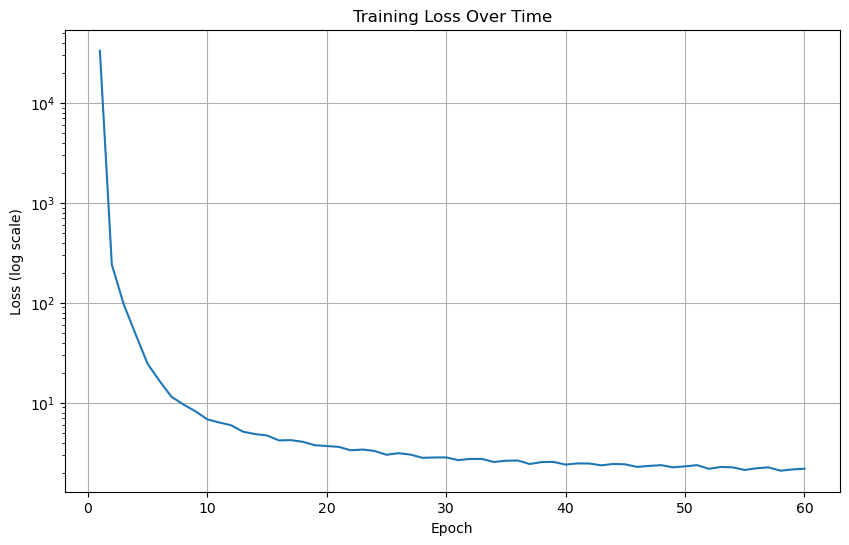

In [26]:
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(losses) + 1), losses)  # Using log scale for y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

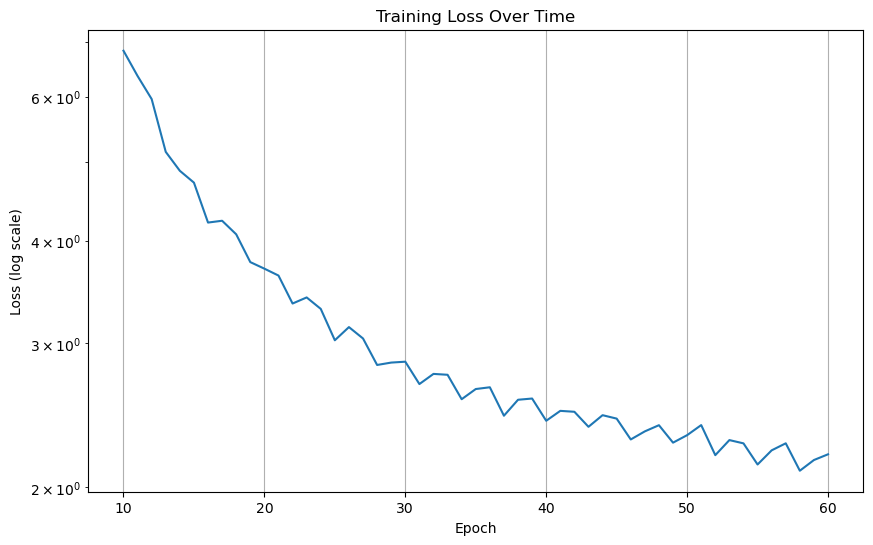

In [31]:
plt.figure(figsize=(10, 6))
plt.semilogy(range(10, len(losses) + 1), losses[9:])  # Using log scale for y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

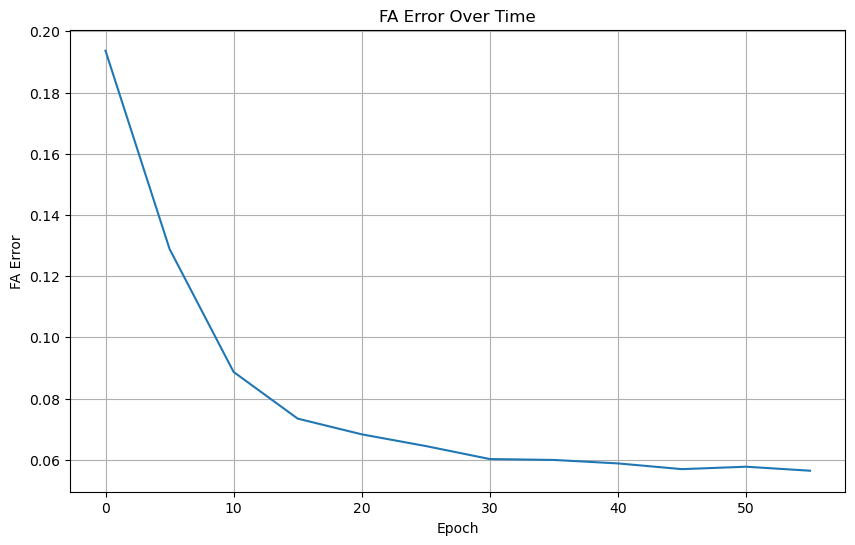

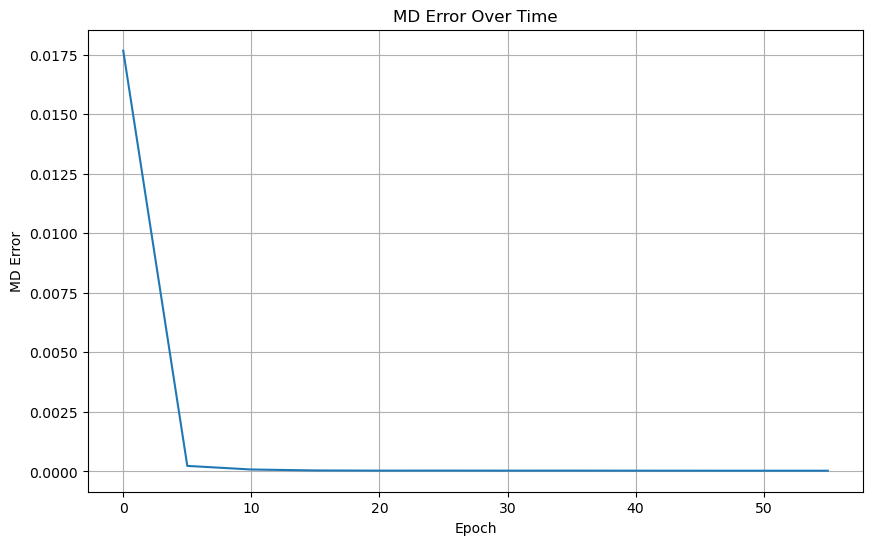

In [27]:
# Plot FA error
plt.figure(figsize=(10, 6))
plt.plot([m['epoch'] for m in all_metrics], [m['fa_error'] for m in all_metrics])
plt.xlabel('Epoch')
plt.ylabel('FA Error')
plt.title('FA Error Over Time')
plt.grid(True)
plt.show()

# Plot MD error
plt.figure(figsize=(10, 6))
plt.plot([m['epoch'] for m in all_metrics], [m['md_error'] for m in all_metrics])
plt.xlabel('Epoch')
plt.ylabel('MD Error')
plt.title('MD Error Over Time')
plt.grid(True)
plt.show()

In [28]:
print("\nStarting Final Evaluation...")
model.eval()
test_losses = []
test_preds = []
test_gts = []

with torch.no_grad():
    # Process all batches, including last partial batch
    for start in range(0, len(test_idx), batch_size):
        end = min(start + batch_size, len(test_idx))
        batch_indices = test_idx[start:end]
        
        # Create graph data using precomputed structures
        nodes, edges, edge_weights, tensors = create_batch_data(
            batch_indices,
            direction_structures_gpu[direction_set_idx],
            features_gpu,
            ground_truth_gpu
        )

        data_list = convert_to_torch_geometric(nodes, edges, edge_weights, tensors)
        batch_data = Batch.from_data_list(data_list).to(device)
        
        # Get predictions
        pred = model(batch_data.x, batch_data.edge_index, batch_data.edge_attr, batch_data.batch)
        
        # Calculate loss
        test_loss = model.weighted_mse_loss(pred, batch_data.y) * 1e6
        test_losses.append(test_loss.item())
        
        # Store predictions and ground truth
        test_preds.append(pred.cpu().numpy())
        test_gts.append(batch_data.y.cpu().numpy())

# Combine results
all_test_preds = np.concatenate(test_preds, axis=0)
all_test_gts = np.concatenate(test_gts, axis=0)
avg_test_loss = np.mean(test_losses)

print(f"\nFinal Test Results:")
print(f"Average test loss: {avg_test_loss:.6f}")

# Use same evaluation function as training
metrics = evaluate_model(all_test_preds, all_test_gts, epoch=-2)

# Print random examples from full test set
print("\nExample predictions vs ground truth (randomly sampled):")
n_examples = 5
rand_indices = np.random.choice(len(all_test_preds), n_examples, replace=False)
for i, idx in enumerate(rand_indices):
    print(f"\nSample {i+1}:")
    print(f"Predicted: {all_test_preds[idx]}")
    print(f"Actual:    {all_test_gts[idx]}")


Starting Final Evaluation...

Final Test Results:
Average test loss: 2.150694

Epoch -1 Statistics:

Relative Errors per component:
Component 0: 3.36e+02
Component 1: 6.21e+02
Component 2: 3.59e+02
Component 3: 7.65e+02
Component 4: 3.44e+02
Component 5: 3.38e+02
Mean Diffusivity Absolute Error: 2.70e-05
FA Absolute Error: 5.33e-02

Prediction Statistics:
Component 0: mean=9.86e-04, std=5.20e-04
Component 1: mean=-5.57e-05, std=1.11e-04
Component 2: mean=1.02e-03, std=5.22e-04
Component 3: mean=-4.84e-05, std=1.07e-04
Component 4: mean=-2.16e-05, std=1.10e-04
Component 5: mean=9.93e-04, std=5.32e-04

Ground Truth Statistics:
Component 0: mean=9.89e-04, std=5.49e-04
Component 1: mean=-1.18e-06, std=1.15e-04
Component 2: mean=1.03e-03, std=5.57e-04
Component 3: mean=3.51e-06, std=1.17e-04
Component 4: mean=-2.23e-05, std=1.20e-04
Component 5: mean=1.00e-03, std=5.63e-04

Example predictions vs ground truth (randomly sampled):

Sample 1:
Predicted: [ 6.5543520e-04 -5.5570155e-05  6.92721

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total trainable parameters: {total_params:,}')

Total trainable parameters: 100,870
